# Walmart : predict weekly sales
- Objective: Build a ML model to predict weekly sales, obtaining highest precision score possible. Explain the influence economic indicators have on sales. 

## Part 1: Exploratory Data Analysis

### Imports

In [3]:
# data manipulation
import pandas as pd
import numpy as np
import scipy.stats as sp
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import random
import datetime

# preprocessing and machine learning
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import pickle

# show all rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("/Users/student/Desktop/SupervisedML/Walmart_Store_sales.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


__Variable Keys__
- Store - the store number
- Date - the week
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week

### Data Exploration

In [5]:
print(f"Rows: {df.shape[0]} \nColumns: {df.shape[1]}")

Rows: 150 
Columns: 8


In [6]:
# missing values
df.isna().sum()

Store            0
Date            18
Weekly_Sales    14
Holiday_Flag    12
Temperature     18
Fuel_Price      14
CPI             12
Unemployment    15
dtype: int64

In [7]:
# drop missing values where weekly sales and date are missing
df.dropna(inplace=True, subset=["Weekly_Sales", "Date"])
df.isna().sum()

Store            0
Date             0
Weekly_Sales     0
Holiday_Flag     9
Temperature     11
Fuel_Price      11
CPI              9
Unemployment    11
dtype: int64

In [8]:
# any duplicates?
df.duplicated().sum()

0

In [9]:
# datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         118 non-null    float64
 1   Date          118 non-null    object 
 2   Weekly_Sales  118 non-null    float64
 3   Holiday_Flag  109 non-null    float64
 4   Temperature   107 non-null    float64
 5   Fuel_Price    107 non-null    float64
 6   CPI           109 non-null    float64
 7   Unemployment  107 non-null    float64
dtypes: float64(7), object(1)
memory usage: 8.3+ KB


In [10]:
# convert "store" and "holiday_flag" to categorical variables
df[["Store", "Holiday_Flag"]] = df[["Store", "Holiday_Flag"]].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Store         118 non-null    category
 1   Date          118 non-null    object  
 2   Weekly_Sales  118 non-null    float64 
 3   Holiday_Flag  109 non-null    category
 4   Temperature   107 non-null    float64 
 5   Fuel_Price    107 non-null    float64 
 6   CPI           109 non-null    float64 
 7   Unemployment  107 non-null    float64 
dtypes: category(2), float64(5), object(1)
memory usage: 7.5+ KB


#### Statistics

In [11]:
# amount of stores
len(np.unique(df["Store"]))

20

In [12]:
# amount of holidays
df["Holiday_Flag"].value_counts()

Holiday_Flag
0.0    101
1.0      8
Name: count, dtype: int64

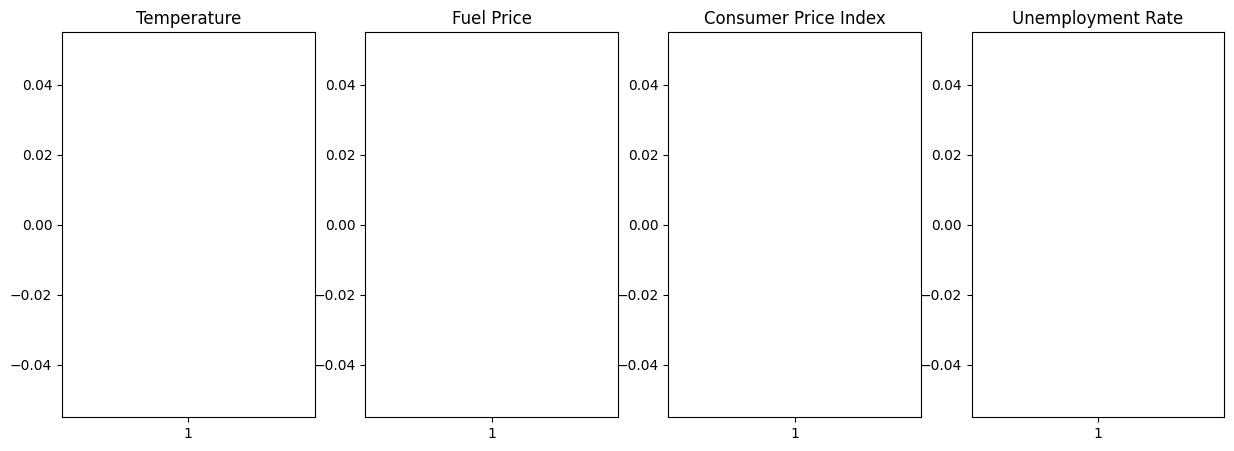

In [13]:
# view distribution for numerical variables

# create subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
fig.set_figwidth(15)
fig.set_figheight(5)

# first chart
ax1.boxplot(df["Temperature"])
ax1.set_title("Temperature")
# second chart
ax2.boxplot(df["Fuel_Price"])
ax2.set_title("Fuel Price")
# third chart
ax3.boxplot(df["CPI"])
ax3.set_title("Consumer Price Index")
# fourth chart
ax4.boxplot(df["Unemployment"])
ax4.set_title("Unemployment Rate")

# show
plt.show()

- _Unemployment_ seems to have several outliers, contrary to other columns. Our threshold for this project is of 3 standard deviations, or $[ X−3σ, X+3σ]$.

In [14]:
# range of -3, +3 sigmas for Unemployment
sigma_plus3 = (df["Unemployment"].mean() + df["Unemployment"].std()*3).round(2)
sigma_minus3 = -(df["Unemployment"].mean() + df["Unemployment"].std()*3).round(2)
sigma_plus3, sigma_minus3

(12.72, -12.72)

In [15]:
# remove outliers with masks
df_outliers = df[(df["Unemployment"] < sigma_plus3) & (df["Unemployment"] > sigma_minus3)]
df_outliers.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896
6,15.0,03-06-2011,695396.19,0.0,69.80,4.069,134.855161,7.658


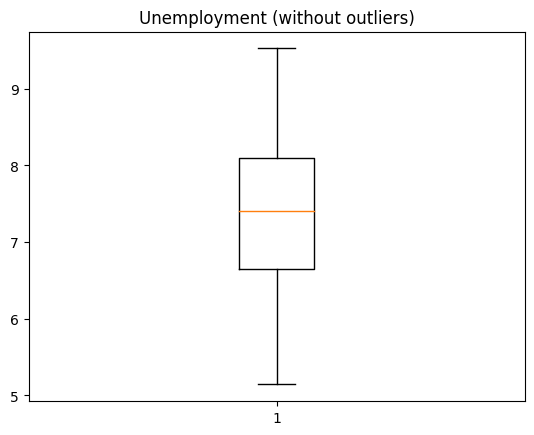

In [16]:
# redraw boxplot for "unemployment", without outliers
plt.boxplot(df_outliers["Unemployment"])
plt.title("Unemployment (without outliers)")
plt.show()

In [17]:
# declare df w/o outliers as normal df
df = df_outliers

### Data Analysis

##### What variables should we explore further?
- Correlation Analysis

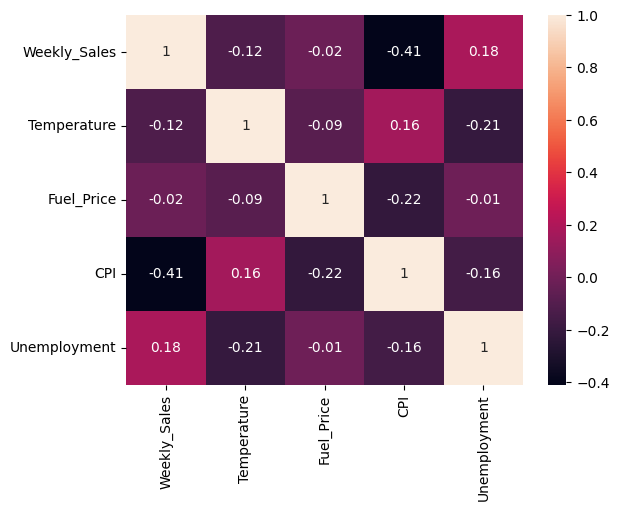

In [18]:
# correlation between numeric features
sns.heatmap(df.select_dtypes(include="number").corr().round(2),
            annot=True)
plt.show()

- CPI (consumer price index) has an important negative correlation with our target variable _weekly sales_, contrary to the rest of the variables. The lower inflation is the lower sales are. 
- Fuel Price and Year have a very strong correlation, it is necessary to drop one of both variables in order to avoid collinearity. Fuel Price will be dropped as Year has a stronger correlation with our target variable.
- Interesting to see that most variables have negative correlations between them.
- CPI seems to be the driver factor here, as it is also correlated to fuel price which makes sense, but higher temperatures lead to a higher CPI. This probably indicates that inflation might be seasonal, we should explore this relationship further with the date column.

##### Weekly Sales

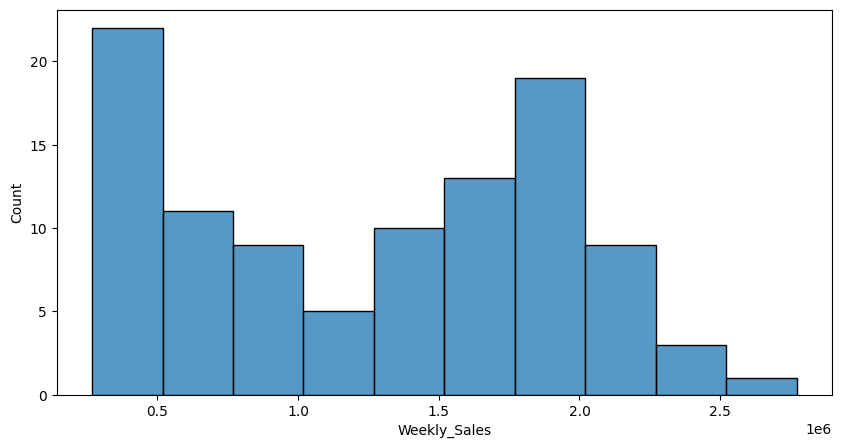

'Weekly sales average:'

1272916.6

In [19]:
# bins of 10, 250.000 each  
plt.figure(figsize=(10,5))
sns.histplot(df["Weekly_Sales"],
             bins=10)
plt.title("")
plt.show()

# average sales per week
display("Weekly sales average:", df["Weekly_Sales"].mean().round(2))

In [20]:
# weekly sales range
df["Weekly_Sales"].min(), df["Weekly_Sales"].max()

(268929.03, 2771397.17)

In [21]:
# create new column with four categories of unemployment rates
df["Weekly_Sales_bins"] = pd.cut(df["Weekly_Sales"], 
                                 bins=4,
                                 labels=["266,426.56, 894,546.065", "894,546.07, 1520163.1", "1,520,163.1, 2,145,780.14", "2,145,780.14, 2,771,397.17"])

df["Weekly_Sales_bins"].head()                

0    1,520,163.1, 2,145,780.14
1    1,520,163.1, 2,145,780.14
4    1,520,163.1, 2,145,780.14
5    1,520,163.1, 2,145,780.14
6      266,426.56, 894,546.065
Name: Weekly_Sales_bins, dtype: category
Categories (4, object): ['266,426.56, 894,546.065' < '894,546.07, 1520163.1' < '1,520,163.1, 2,145,780.14' < '2,145,780.14, 2,771,397.17']

##### How does unemployment affect weekly sales?

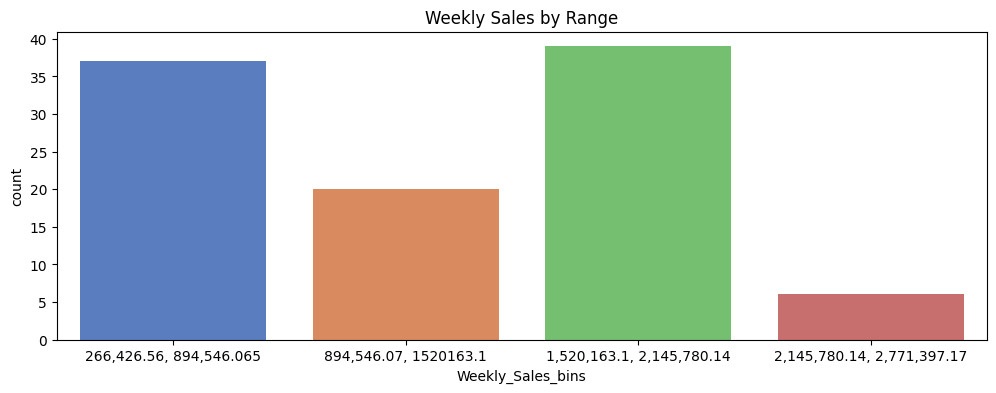

In [22]:
# read x_labels as "less than x"

plt.figure(figsize=(12,4))
sns.countplot(data=df,
              x="Weekly_Sales_bins",
              palette="muted")
plt.title("Weekly Sales by Range")
plt.show()

##### Which are the best selling stores?

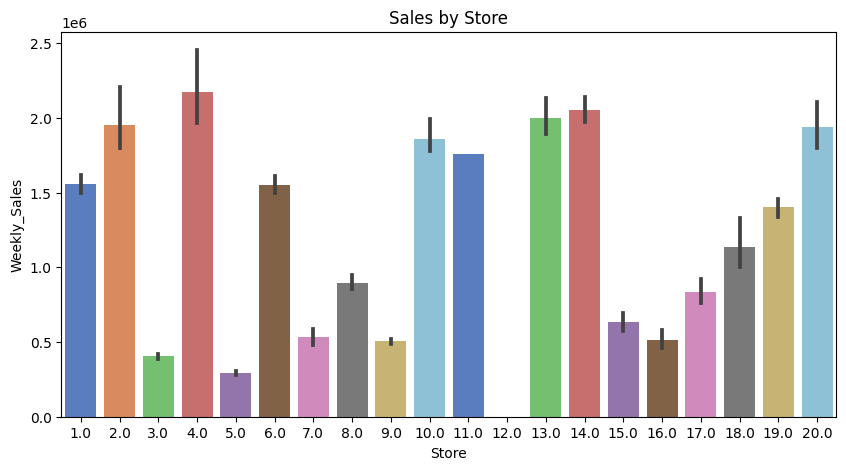

In [23]:
plt.figure(figsize=(10,5))
sns.barplot(data=df,
            x="Store",
            y="Weekly_Sales",
            palette="muted")
plt.title("Sales by Store")
plt.show()

- The stores with the most sales are 4, 10, 13, 14 and 20.

#### Are weekly sales affected by unemployment?

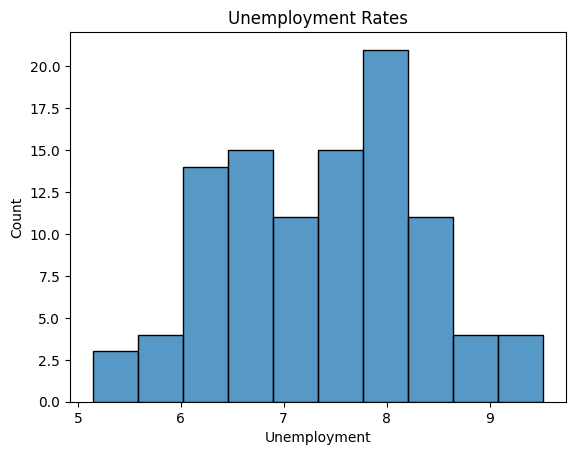

Average Unemployment Rate 7.38


In [24]:
sns.histplot(df["Unemployment"],
             bins=10)
plt.title("Unemployment Rates")
plt.show()

# show rounded mean
print("Average Unemployment Rate", df["Unemployment"].mean().round(2))

In [25]:
# create new column with four categories of unemployment rates
df["Unemployment_bins"] = pd.cut(df["Unemployment"], 
                                 bins=4,
                                 labels=["5.14, 6.19", "6.19, 7.24", "7.24, 8.29", "8.29, 9.34"])
df["Unemployment_bins"].head()

0    6.19, 7.24
1    7.24, 8.29
4    6.19, 7.24
5    7.24, 8.29
6    7.24, 8.29
Name: Unemployment_bins, dtype: category
Categories (4, object): ['5.14, 6.19' < '6.19, 7.24' < '7.24, 8.29' < '8.29, 9.34']

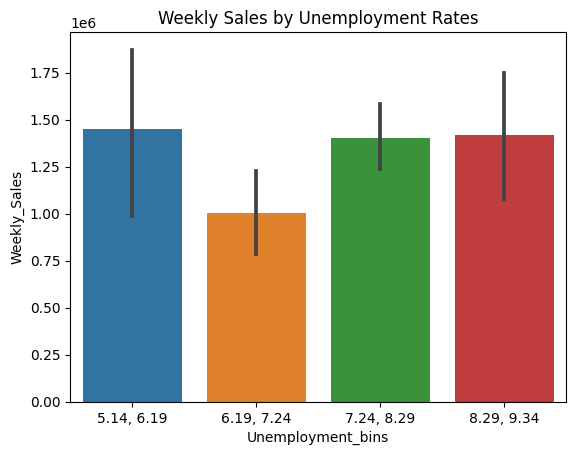

In [26]:
# how does unemployment affect weekly sales?
sns.barplot(data=df,
            x="Unemployment_bins",
            y="Weekly_Sales")
plt.title("Weekly Sales by Unemployment Rates")
plt.show()

- Unemployment does not seem to have much impact on weekly sales, as sales are not very different when employment is high as when it is low. 

#### What is the impact of CPI against Weekly Sales?

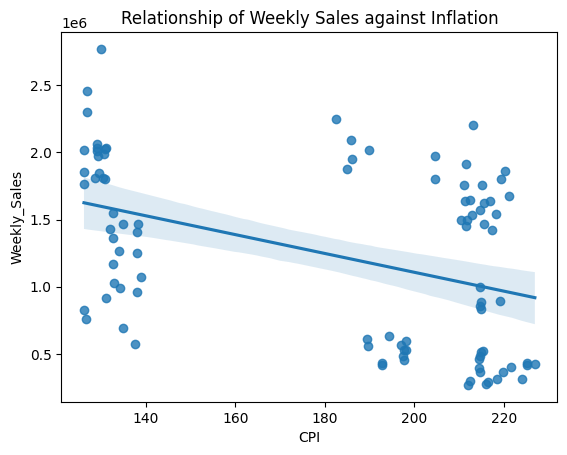

Average inflation (CPI): 180.35


In [27]:
sns.regplot(data=df,
            x="CPI",
            y="Weekly_Sales")
plt.title("Relationship of Weekly Sales against Inflation")
plt.show()

print("Average inflation (CPI):", df["CPI"].mean().round(2))

- Logically, the higher inflation is the lower weekly sales will be.

In [28]:
# CPI range
df["CPI"].min().round(2), df["CPI"].max().round(2)

(126.13, 226.97)

In [29]:
# sort rows to different labeled bins 
df["CPI_bins"] = pd.cut(df["CPI"],
                        bins=5,
                        labels=["125.9, 146.2", "146.2, 166.4", "166.4, 186.6", "186.6, 206.8", "206.8, 227.0"])
df["CPI_bins"].head()

0    206.8, 227.0
1    125.9, 146.2
4    206.8, 227.0
5    125.9, 146.2
6    125.9, 146.2
Name: CPI_bins, dtype: category
Categories (5, object): ['125.9, 146.2' < '146.2, 166.4' < '166.4, 186.6' < '186.6, 206.8' < '206.8, 227.0']

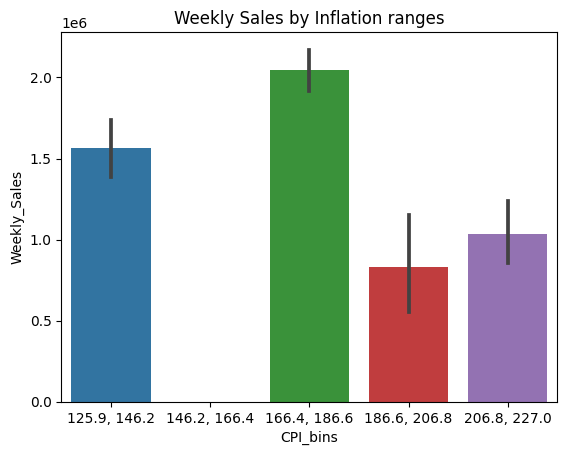

In [30]:
sns.barplot(data=df,
            x="CPI_bins",
            y="Weekly_Sales")
plt.title("Weekly Sales by Inflation ranges")
plt.show()

##### Do sales increase on holidays?

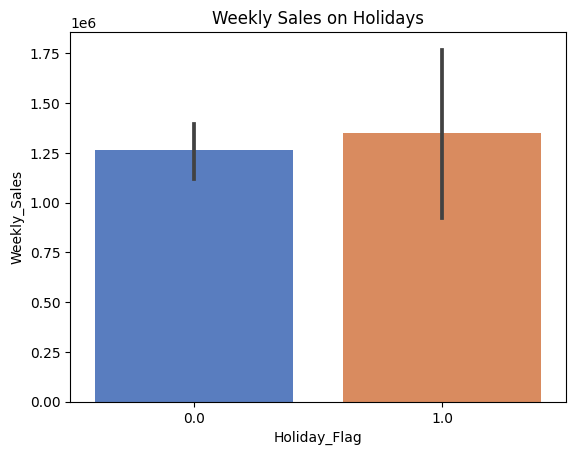

In [31]:
sns.barplot(data=df,
            x="Holiday_Flag",
            y="Weekly_Sales",
            palette="muted")
plt.title("Weekly Sales on Holidays")
plt.show()

In [32]:
# weekly sales when there is no holiday
sales_no_holiday = df[df["Holiday_Flag"]==0]["Weekly_Sales"].mean().round(2)
print("Average sales when there is no holiday:", sales_no_holiday)

Average sales when there is no holiday: 1263802.15


In [33]:
# weekly sales when there is holiday
sales_holiday = df[df["Holiday_Flag"]==1]["Weekly_Sales"].mean().round(2)
print("Average sales when there is holiday:", sales_holiday)


Average sales when there is holiday: 1347476.1


In [34]:
# difference sales when there is holiday and when there is not
print(f"Weekly sales increase by {(sales_holiday - sales_no_holiday).round(2)} when there is a holiday.")

Weekly sales increase by 83673.95 when there is a holiday.


##### Does temperature affect sales?

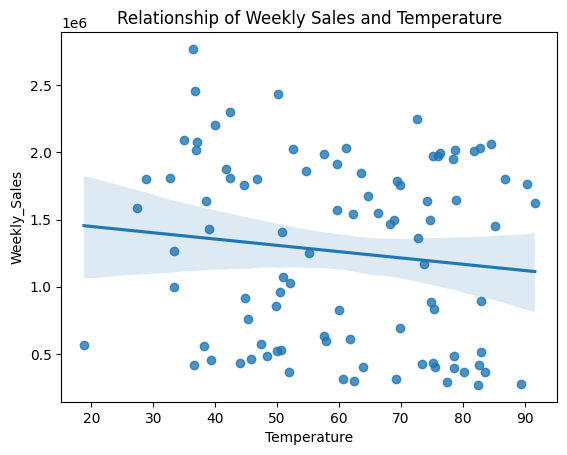

Average temperature: 60.24


In [35]:
sns.regplot(data=df,
            x="Temperature",
            y="Weekly_Sales")
plt.title("Relationship of Weekly Sales and Temperature")
plt.show()

print("Average temperature:", df["Temperature"].mean().round(2))

- No relationship at all between temperature and sales.

##### Does fuel price affect sales?

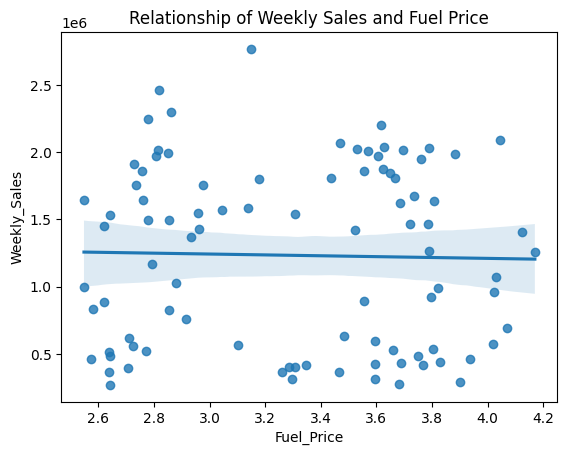

Average fuel price: 3.3


In [36]:
sns.regplot(data=df,
            x="Fuel_Price",
            y="Weekly_Sales")
plt.title("Relationship of Weekly Sales and Fuel Price")
plt.show()

print("Average fuel price:", df["Fuel_Price"].mean().round(2))

- No relationship at all between sales and fuel price.

##### Date

In [37]:
df["Date"].head()

0    18-02-2011
1    25-03-2011
4    28-05-2010
5    28-05-2010
6    03-06-2011
Name: Date, dtype: object

In [38]:
# missing values
df["Date"].isna().sum()

0

In [39]:
# change "date" to datetime type
df["Date"] = pd.to_datetime(df["Date"])
df["Date"].head()

0   2011-02-18
1   2011-03-25
4   2010-05-28
5   2010-05-28
6   2011-06-03
Name: Date, dtype: datetime64[ns]

In [40]:
# drop values where dates are missing
df.dropna(inplace=True, subset="Date")
df.isna().sum()

Store                 0
Date                  0
Weekly_Sales          0
Holiday_Flag          9
Temperature           8
Fuel_Price           10
CPI                   8
Unemployment          0
Weekly_Sales_bins     0
Unemployment_bins     0
CPI_bins              8
dtype: int64

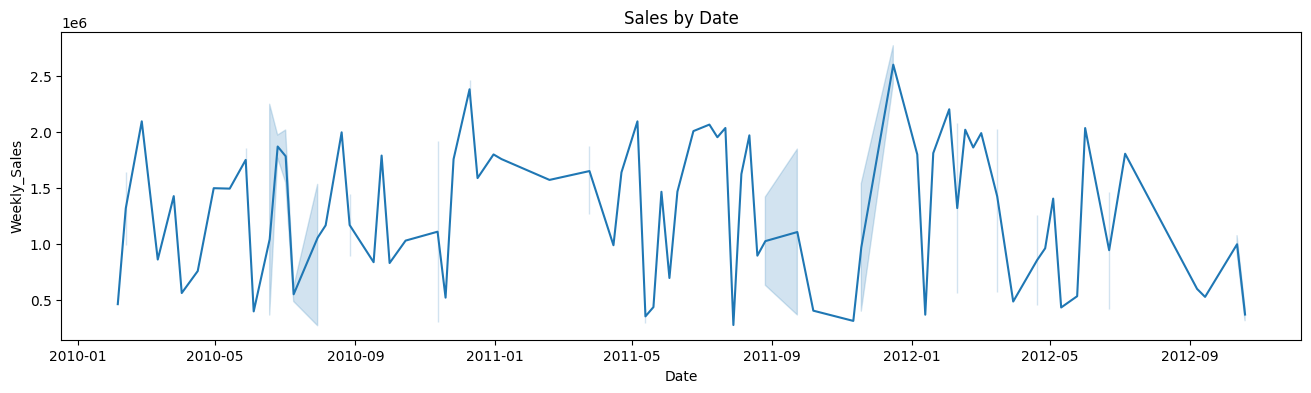

In [41]:
plt.figure(figsize=(16,4))
sns.lineplot(data=df,
             x="Date",
             y="Weekly_Sales")
plt.title("Sales by Date")
plt.show()

In [42]:
# create new columns for day month and year
df["Day"] = df["Date"].dt.day
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year

df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales_bins,Unemployment_bins,CPI_bins,Day,Month,Year
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,"1,520,163.1, 2,145,780.14","6.19, 7.24","206.8, 227.0",18,2,2011
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,"1,520,163.1, 2,145,780.14","7.24, 8.29","125.9, 146.2",25,3,2011
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,"1,520,163.1, 2,145,780.14","6.19, 7.24","206.8, 227.0",28,5,2010
5,4.0,2010-05-28,1857533.70,0.0,NaN,2.756,126.160226,7.896,"1,520,163.1, 2,145,780.14","7.24, 8.29","125.9, 146.2",28,5,2010
6,15.0,2011-06-03,695396.19,0.0,69.80,4.069,134.855161,7.658,"266,426.56, 894,546.065","7.24, 8.29","125.9, 146.2",3,6,2011


##### What day of the month was the one with most sales?

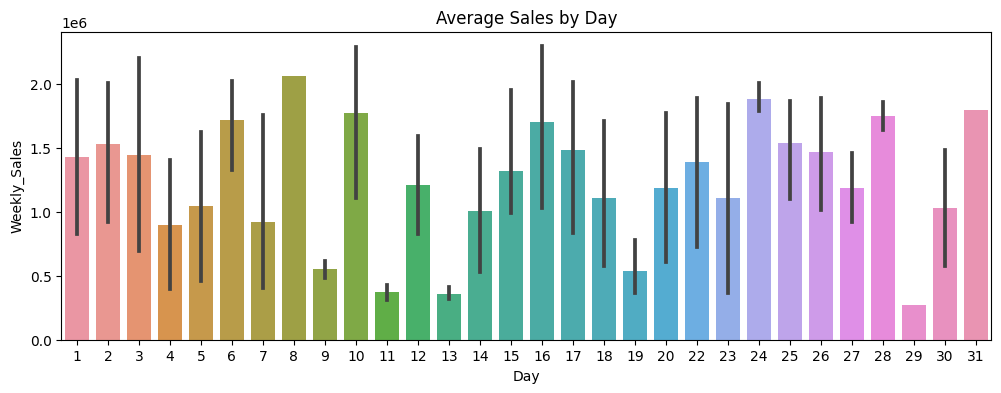

In [43]:
plt.figure(figsize=(12,4))
sns.barplot(data=df,
            x="Day",
            y="Weekly_Sales")
plt.title("Average Sales by Day")
plt.show()

In [44]:
# df with numerical variables only, to make groupby
df_num = df.select_dtypes("number")

In [45]:
# 10 days with the most sales
df_num.groupby(by="Day").mean()["Weekly_Sales"].sort_values(ascending=False).head(10)

Day
8     2.066542e+06
24    1.886612e+06
31    1.799738e+06
10    1.774433e+06
28    1.751002e+06
6     1.716809e+06
16    1.705923e+06
25    1.537935e+06
2     1.529712e+06
17    1.481897e+06
Name: Weekly_Sales, dtype: float64

##### What month was the one with the most sales?

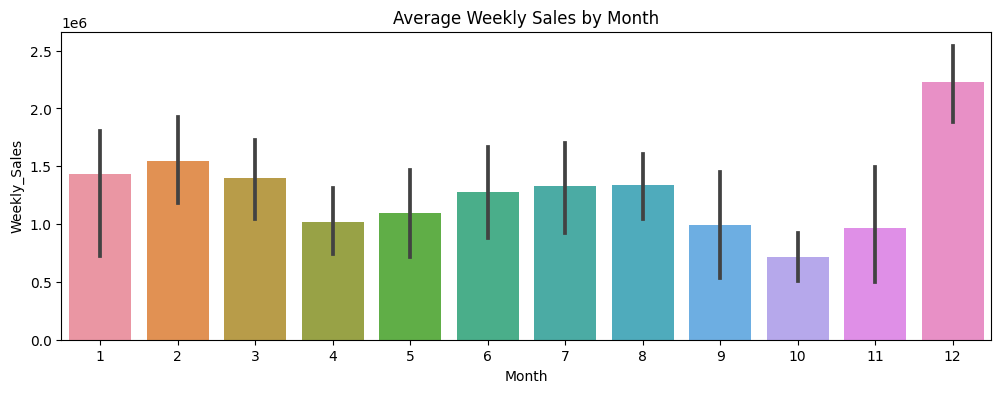

In [46]:
plt.figure(figsize=(12,4))
sns.barplot(data=df,
            x="Month",
            y="Weekly_Sales")
plt.title("Average Weekly Sales by Month")
plt.show()

In [47]:
# 3 months with the most sales
df_num.groupby(by="Month").mean()["Weekly_Sales"].sort_values(ascending=False).head(3)

Month
12    2226045.900
2     1549268.413
1     1434153.940
Name: Weekly_Sales, dtype: float64

##### How have sales changed by year?

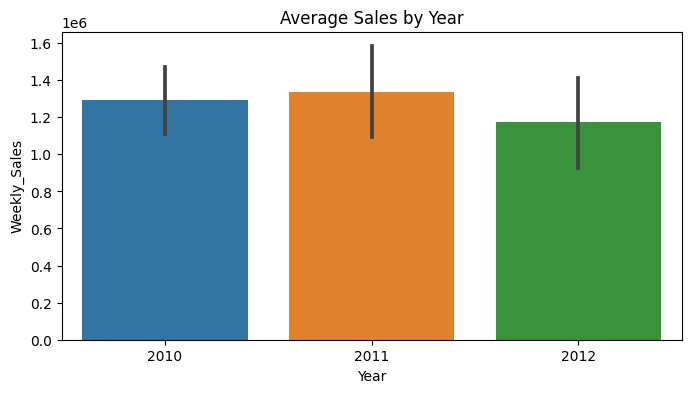

In [48]:
plt.figure(figsize=(8,4))
sns.barplot(data=df,
            x="Year",
            y="Weekly_Sales")
plt.title("Average Sales by Year")
plt.show()

Change in total sales from 2010 to 2011


In [49]:
(df[df["Year"]==2011]["Weekly_Sales"].mean() - df[df["Year"]==2010]["Weekly_Sales"].mean()).round(2)

41844.74

Change in total sales from 2011 to 2012


In [50]:
# change from 2011 to 2012
(df[df["Year"]==2012]["Weekly_Sales"].mean().round(2) - df[df["Year"]==2011]["Weekly_Sales"].mean()).round(2)

-159924.23

##### Heatmap with _Date_

### Model Preprocessing
Steps:
- Split X and Y
- Train-Test Split


- Normalize X
- Impute missing values
- Get dummy variables for X

It is not necessary to create the whole pipeline, as for categorical varianles the only necessary step is to create dummy variables. Hence, only a …



In [51]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales_bins',
       'Unemployment_bins', 'CPI_bins', 'Day', 'Month', 'Year'],
      dtype='object')

In [52]:
# declare x and y
# drop target variable
# drop columns created for EDA
# drop Date, as it was transformed into other three columns
# drop Fuel Price, because of correlation with Year variable
X = df.drop(["Weekly_Sales", "Weekly_Sales_bins", "Unemployment_bins", "CPI_bins", "Date", "Fuel_Price"], axis=1)
y = df["Weekly_Sales"]

display(X.head())
display(y.head())

,Store,Holiday_Flag,Temperature,CPI,Unemployment,Day,Month,Year
0,6.0,NaN,59.61,214.777523,6.858,18,2,2011
1,13.0,0.0,42.38,128.616064,7.470,25,3,2011
4,6.0,0.0,78.89,212.412888,7.092,28,5,2010
5,4.0,0.0,NaN,126.160226,7.896,28,5,2010
6,15.0,0.0,69.80,134.855161,7.658,3,6,2011


0    1572117.54
1    1807545.43
4    1644470.66
5    1857533.70
6     695396.19
Name: Weekly_Sales, dtype: float64

In [53]:
# create dummy columns for Store and Holiday
X = pd.get_dummies(X, drop_first=True,dtype="float")
X.head()

,Temperature,CPI,Unemployment,Day,Month,Year,Store_2.0,Store_3.0,Store_4.0,Store_5.0,Store_6.0,Store_7.0,Store_8.0,Store_9.0,Store_10.0,Store_11.0,Store_12.0,Store_13.0,Store_14.0,Store_15.0,Store_16.0,Store_17.0,Store_18.0,Store_19.0,Store_20.0,Holiday_Flag_1.0
0,59.61,214.777523,6.858,18,2,2011,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,42.38,128.616064,7.470,25,3,2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,78.89,212.412888,7.092,28,5,2010,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,NaN,126.160226,7.896,28,5,2010,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,69.80,134.855161,7.658,3,6,2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# train test split
# train 80%, test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# sanity check 
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(81, 26) (21, 26)
(81,) (21,)


In [55]:
# save columns, so they are not lost when X is an array
X_columns = X_train.columns
X_columns

Index(['Temperature', 'CPI', 'Unemployment', 'Day', 'Month', 'Year',
       'Store_2.0', 'Store_3.0', 'Store_4.0', 'Store_5.0', 'Store_6.0',
       'Store_7.0', 'Store_8.0', 'Store_9.0', 'Store_10.0', 'Store_11.0',
       'Store_12.0', 'Store_13.0', 'Store_14.0', 'Store_15.0', 'Store_16.0',
       'Store_17.0', 'Store_18.0', 'Store_19.0', 'Store_20.0',
       'Holiday_Flag_1.0'],
      dtype='object')

In [56]:
# impute missing values on X using k nearest neigbohrs technique
imputer = KNNImputer(n_neighbors=5)
X_train = imputer.fit_transform(X_train)
X_test = imputer.fit_transform(X_test)

# use dataframe, as now X is an array
pd.DataFrame(X_train).isna().sum().sum()

0

## Part 2: Train baseline model

### Baseline Model

R2 score for TRAIN set:, 0.9742
R2 score for TEST set:, 0.9477
Difference between train and test: 0.0265


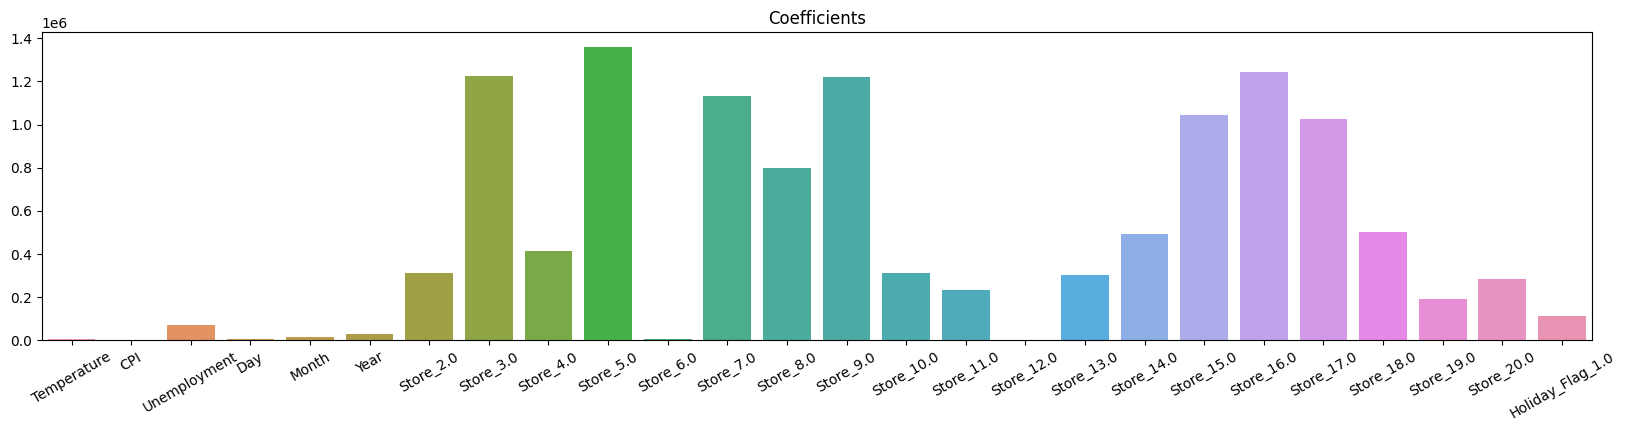

,Coefficients
Store_5.0,1360560.87
Store_16.0,1241495.99
Store_3.0,1226386.47
Store_9.0,1218945.36
Store_7.0,1133502.09
Store_15.0,1042603.10
Store_17.0,1025356.10
Store_8.0,800783.87
Store_18.0,503901.10
Store_14.0,493207.81


In [57]:
# set random seed
random.seed(1)

# train model
baseline = LinearRegression()
baseline.fit(X_train, y_train)

# print R2 scores
baseline_train_score = baseline.score(X_train, y_train).round(4)
baseline_test_score = baseline.score(X_test, y_test).round(4)

print(f"R2 score for TRAIN set:, {baseline_train_score}")
print(f"R2 score for TEST set:, {baseline_test_score}")
print("Difference between train and test:", (baseline_train_score - baseline_test_score).round(4))

# plot coefficients of linear model
# use absolute value to measure magnitude of coefficients
plt.figure(figsize=(20,4))
sns.barplot(x=X_columns,
            y=abs(baseline.coef_))
plt.xticks(rotation=30)
plt.title("Coefficients")
plt.show()

# make dataframe with coefficients, in descending order
pd.DataFrame(abs(baseline.coef_),
            index=X_columns).rename(columns={0:"Coefficients"}).round(2).sort_values(by="Coefficients", ascending=False)

### Baseline Model with Normalization

In [58]:
# normalize X 
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

# view first observation
X_train[0]

array([4.57100000e+01, 2.14424881e+02, 7.36800000e+00, 5.00000000e+00,
       2.00000000e+00, 2.01000000e+03, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

R2 score for TRAIN set:, 0.9742
R2 score for TEST set:, 0.9162
Difference between train and test: 0.058


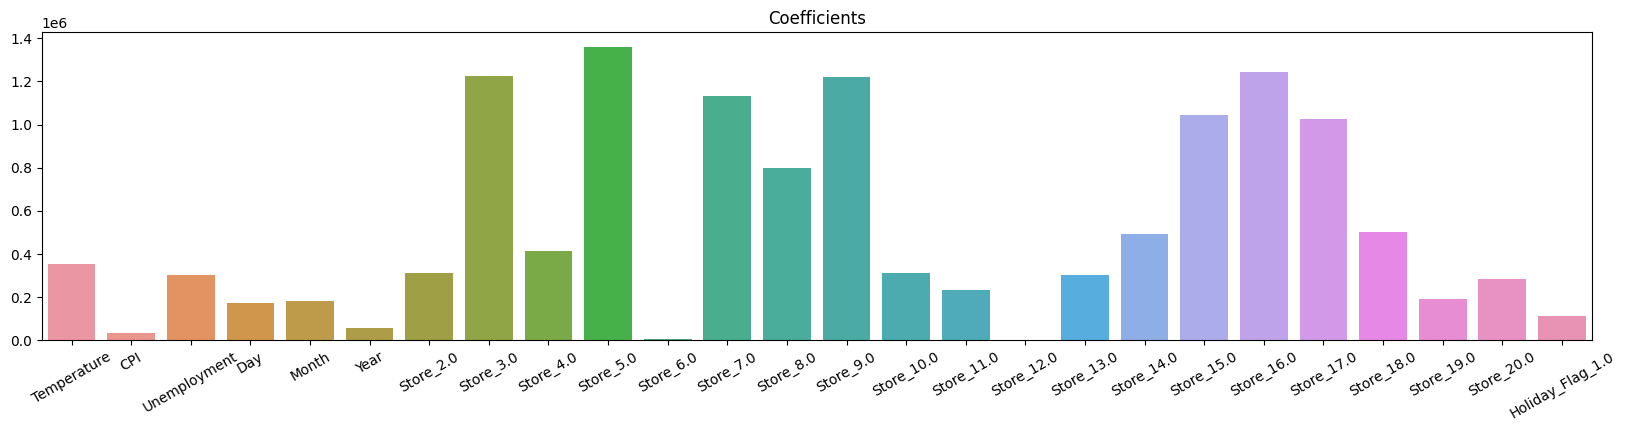

,Coefficients
Store_5.0,1360560.87
Store_16.0,1241495.99
Store_3.0,1226386.47
Store_9.0,1218945.36
Store_7.0,1133502.09
Store_15.0,1042603.10
Store_17.0,1025356.10
Store_8.0,800783.87
Store_18.0,503901.10
Store_14.0,493207.81


In [59]:
# set random seed
random.seed(2)

# train model
baseline_norm = LinearRegression()
baseline_norm.fit(X_train_norm, y_train)

# print R2 scores
baseline_norm_train_score = baseline_norm.score(X_train_norm, y_train).round(4)
baseline_norm_test_score = baseline_norm.score(X_test_norm, y_test).round(4)

print(f"R2 score for TRAIN set:, {baseline_norm_train_score}")
print(f"R2 score for TEST set:, {baseline_norm_test_score}")
print("Difference between train and test:", (baseline_norm_train_score - baseline_norm_test_score).round(4))

# plot coefficients of linear model
# use absolute value to measure magnitude of coefficients
plt.figure(figsize=(20,4))
sns.barplot(x=X_columns,
            y=abs(baseline_norm.coef_))
plt.xticks(rotation=30)
plt.title("Coefficients")
plt.show()

# make dataframe with coefficients, in descending order
pd.DataFrame(abs(baseline_norm.coef_),
            index=X_columns).rename(columns={0:"Coefficients"}).round(2).sort_values(by="Coefficients", ascending=False)

#### Baseline comparison

In [60]:
comparison_baseline_dict = {"Train":[baseline_train_score, baseline_norm_train_score],
                   "Test":[baseline_test_score, baseline_norm_test_score]}

comparison_baseline = pd.DataFrame.from_dict(comparison_baseline_dict)
comparison_baseline.index = ["Baseline", "Baseline Normalized"]

display(comparison_baseline)

,Train,Test
Baseline,0.9742,0.9477
Baseline Normalized,0.9742,0.9162


##### Baseline Models Observations
- Both models have very good train and test scores.
- Coefficients are enormous, but it is not surprising as our target variable is the same size.
- Train scores are the same but the baseline model performs a little bit worse on test data.
- The normalized model takes into account more features, while the not normalized model puts a lot of emphasis on the _Store_ variable.

###### Conclusion on Model
- We will proceed with the non-normalized version of the baseline model, as it has a slightly better performance on the test set. The only disadvantage is that as data is not normalized it might take a little more computing power, but performance is expected to be better.

## Part 3: Train regularized model
- L1, or Lasso
- L2, or Ridge

### Lasso
- Lasso Regressor

R2 score for TRAIN set:, 0.9742
R2 score for TEST set:, 0.9477
Difference between train and test: 0.0265


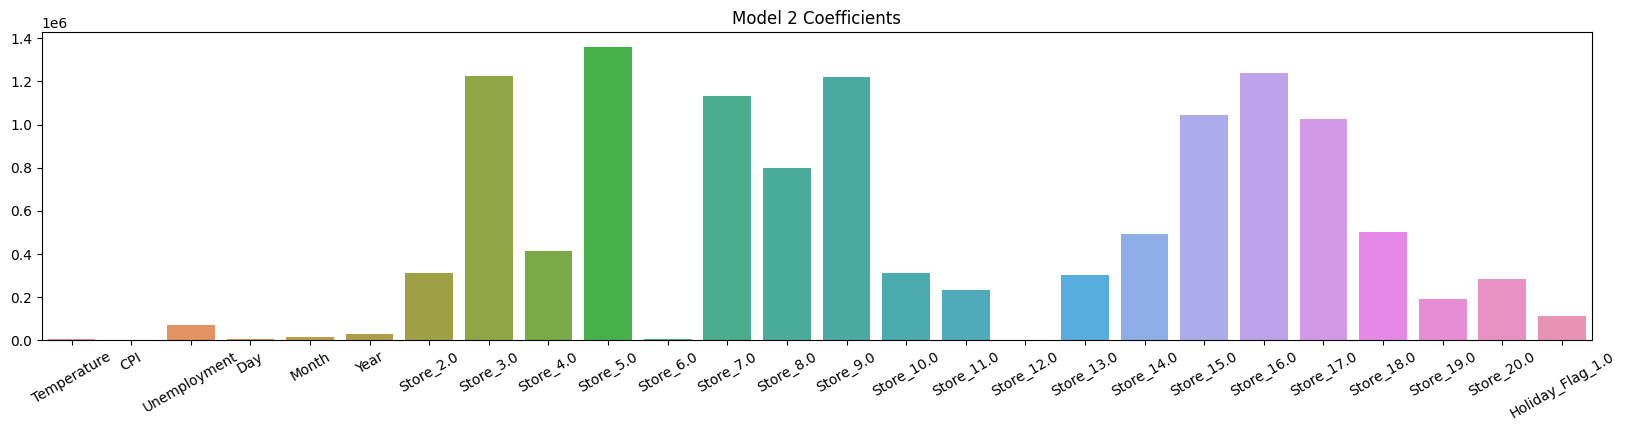

,Coefficients
Store_5.0,1360467.59
Store_16.0,1241374.68
Store_3.0,1226320.21
Store_9.0,1218827.44
Store_7.0,1133463.79
Store_15.0,1042471.27
Store_17.0,1025183.14
Store_8.0,800665.68
Store_18.0,503859.41
Store_14.0,493193.01


In [61]:
# train model
lasso = Lasso(random_state=1)
lasso.fit(X_train, y_train)

# print R2 scores
lasso_train_score = lasso.score(X_train, y_train).round(4)
lasso_test_score = lasso.score(X_test, y_test).round(4)

print(f"R2 score for TRAIN set:, {lasso_train_score}")
print(f"R2 score for TEST set:, {lasso_test_score}")
print("Difference between train and test:", (lasso_train_score - lasso_test_score).round(4))

# plot coefficients of linear model
# use absolute value to measure magnitude of coefficients
plt.figure(figsize=(20,4))
sns.barplot(x=X_columns,
            y=abs(lasso.coef_))
plt.xticks(rotation=30)
plt.title("Model 2 Coefficients")
plt.show()

# make dataframe with coefficients, in descending order
pd.DataFrame(abs(lasso.coef_),
            index=X_columns).rename(columns={0:"Coefficients"}).round(2).sort_values(by="Coefficients", ascending=False)

### Ridge
- Ridge

R2 score for TRAIN set:, 0.9214
R2 score for TEST set:, 0.9023
Difference between train and test: 0.0191


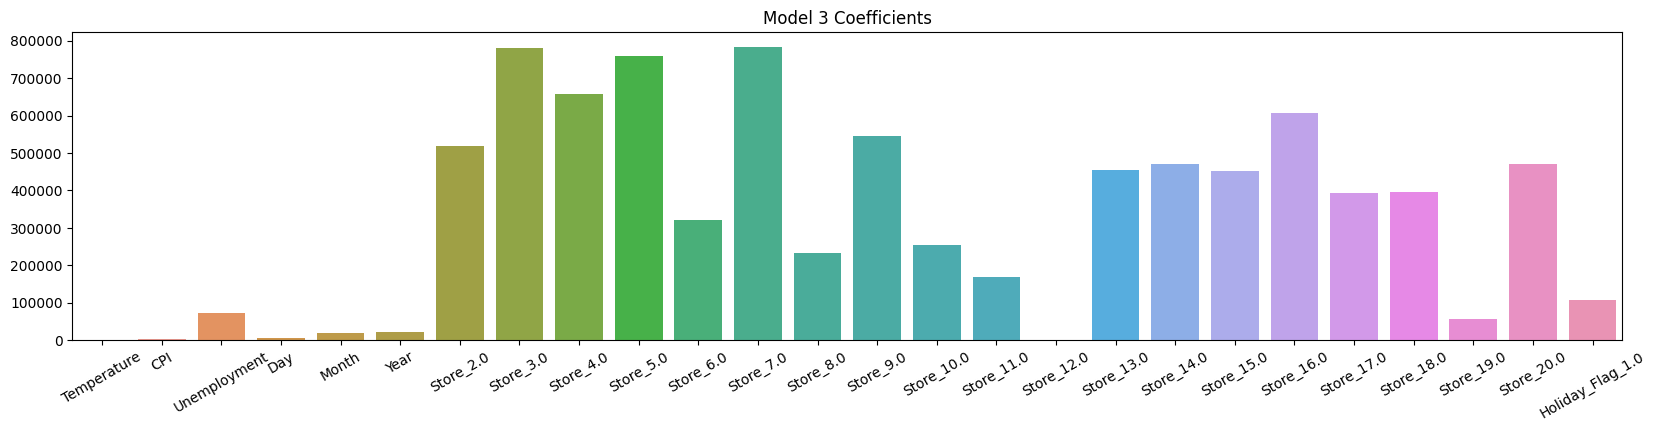

,Coefficients
Store_7.0,783665.99
Store_3.0,781672.33
Store_5.0,760307.32
Store_4.0,658758.74
Store_16.0,605548.13
Store_9.0,546153.45
Store_2.0,517674.81
Store_20.0,471512.65
Store_14.0,471394.54
Store_13.0,455538.12


In [62]:
# train model
ridge = Ridge(random_state=1)
ridge.fit(X_train, y_train)

# print R2 scores
ridge_train_score = ridge.score(X_train, y_train).round(4)
ridge_test_score = ridge.score(X_test, y_test).round(4)

print(f"R2 score for TRAIN set:, {ridge_train_score}")
print(f"R2 score for TEST set:, {ridge_test_score}")
print("Difference between train and test:", (ridge_train_score - ridge_test_score).round(4))

# plot coefficients of linear model
# use absolute value to measure magnitude of coefficients
plt.figure(figsize=(20,4))
sns.barplot(x=X_columns,
            y=abs(ridge.coef_))
plt.xticks(rotation=30)
plt.title("Model 3 Coefficients")
plt.show()

# make dataframe with coefficients, in descending order
pd.DataFrame(abs(ridge.coef_),
            index=X_columns).rename(columns={0:"Coefficients"}).round(2).sort_values(by="Coefficients", ascending=False)

### Model Comparisons

In [63]:
# create dataframe using a dictionary, in order to compare all scores

comparison_dict = {"Train":[baseline_train_score, baseline_norm_train_score, lasso_train_score, ridge_train_score],
                   "Test":[baseline_test_score, baseline_norm_test_score, lasso_test_score, ridge_test_score]}

comparison = pd.DataFrame.from_dict(comparison_dict)
comparison.index = ["Baseline", "Baseline Normalized", "Lasso", "Ridge"]

display(comparison)

,Train,Test
Baseline,0.9742,0.9477
Baseline Normalized,0.9742,0.9162
Lasso,0.9742,0.9477
Ridge,0.9214,0.9023


- Baseline and Lasso models have exactly the same scores, but generally Lasso is better because it is a regularized model and avoids overfitting.
- We will do a Grid Search on Lasso. 

### Lasso GridSearchCV

In [64]:
# perform grid search on Lasso
lasso_params = {'alpha':[0.01, 0.15, 0.02, 0.0225, 0.025, 0.0275, 0.03]}             
gridsearch = GridSearchCV(estimator=lasso, param_grid=lasso_params)
gridsearch.fit(X_train, y_train)
print("Best parameters:", gridsearch.best_params_, "\nBest score:", gridsearch.best_score_.round(4))

Best parameters: {'alpha': 0.01} 
Best score: 0.897


- Grid Search does not improve our accuracy, in fact it decreases by a few points so it is better to remain with the previously trained Lasso model.

## Conclusions & Recommendations
- After the training of five models, our best model was the Lasso, obtaining a test $R^2$ score of 94.77%. The model can now be safely used to predict weekly sales for all 20 of Walmart's stores.

In [77]:
# name of pickle, format=write binary
lasso_pickle_save = open("lasso.pickle", "wb")
# serialization, in other words, convert into a file
pickle.dump(lasso, lasso_pickle_save)
# close file
lasso_pickle_save.close()

In [81]:
# open pickle
# name of file, format=read binary
load_lasso_pickle = open("lasso.pickle", "rb")
# name of uploaded file
lasso = pickle.load(load_lasso_pickle)
print(lasso)

Lasso(random_state=1)
